In [1]:
# !pip install sentence-transformers
# !pip install transformers
# !pip install sacremoses
# !pip install umap-learn
# # !pip install hdbscan

In [2]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.base import clone as sklearn_clone

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel, HerbertTokenizer, BatchEncoding

import gc
from sklearn.neighbors import KNeighborsClassifier

from scipy import spatial
import umap.umap_ as umap

/home/marek/anaconda3/envs/nlp/lib/python3.9/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


In [3]:
torch.manual_seed(111)
np.random.seed(111)
random.seed(111)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()
    
device.type

'cuda'

## Get data

In [4]:
df_topics = pd.read_csv('../datasets/ready2use/topics.csv', index_col=0)

In [5]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_combined.csv', sep=';')

df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

df = df.copy()[['assestment', 'text_clean']][df.index.isin(df_topics.index)].reset_index(drop=True)

In [6]:
embeddings_table = pd.read_csv('../datasets/ready2use/embeddings_pl_herbert.csv', sep=",", header=None).values

## Kfold

In [7]:
cv_fold = []
cv_fold_i = []

for i in df_topics['topic'].unique().reshape(10,-1):
    train_cv = df_topics.index[ ~np.isin(df_topics["topic"], [i, np.mod(i+1,10)]) ].values
    val_cv = df_topics.index[ np.isin(df_topics["topic"], np.mod(i+1,10)) ].values
    test_cv = df_topics.index[ np.isin(df_topics["topic"], i) ].values
    
    train_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], [i, np.mod(i+1,10)]) ].values
    val_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], np.mod(i+1,10)) ].values
    test_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], i) ].values
    
    cv_fold.append( [train_cv, val_cv, test_cv])
    cv_fold_i.append( [train_cv_i, val_cv_i, test_cv_i])

In [8]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(df_topics)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(df_topics):
    train_index, val_index = train_test_split(train_index, test_size=1/9, shuffle=True)
    train_cv = df_topics.iloc[ train_index, : ].index.values
    val_cv = df_topics.iloc[ val_index, : ].index.values
    test_cv = df_topics.iloc[ test_index, : ].index.values

    train_cv_i= df_topics.reset_index().iloc[ train_index, : ].index.values
    val_cv_i = df_topics.reset_index().iloc[ val_index, : ].index.values
    test_cv_i = df_topics.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, val_cv, test_cv])
    cv_Kfold_i.append( [train_cv_i, val_cv_i, test_cv_i])

## Train

## TripletLoss

In [9]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [10]:
class TripletLossVector():
    def __init__(self, margin=1.0):
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def get_loss(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        
        return losses

## Visualise test with UMAP

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
train_index, val_index, test_index = cv_fold_i[0]
y_train = df['assestment'].values[train_index]
y_val = df['assestment'].values[val_index]
y_test = df['assestment'].values[test_index]

unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

scaler = StandardScaler().fit(embeddings_table[train_index])

[[   0 2756]
 [   1 2514]]


In [13]:
reducer = umap.UMAP()
umap_train = reducer.fit_transform(scaler.transform(embeddings_table[train_index]), y=y_train)
umap_val = reducer.transform(scaler.transform(embeddings_table[val_index]))
umap_test = reducer.transform(scaler.transform(embeddings_table[test_index]))

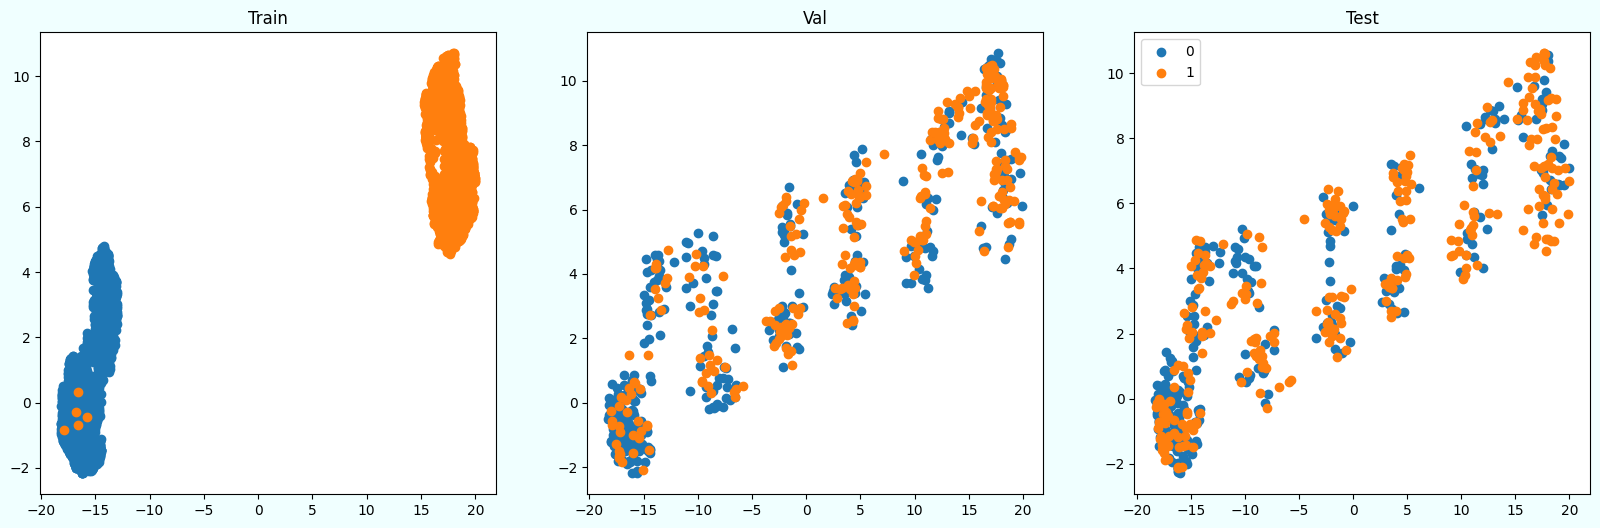

In [14]:
plt.figure(figsize=(20, 6), facecolor="azure")

plt.subplot(1, 3, 1)
for label in np.unique(y_train):
    tmp = umap_train[y_train==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    plt.title('Train')
    
plt.subplot(1, 3, 2)
for label in np.unique(y_val):
    tmp = umap_val[y_val==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    plt.title('Val')

plt.subplot(1, 3, 3)
for label in np.unique(y_test):
    tmp = umap_test[y_test==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    plt.title('Test')

plt.legend()
plt.show()

## Run KNN and determine badly calssified

In [15]:
# neigh = KNeighborsClassifier(n_neighbors=int(np.sqrt(train_index.shape[0])))
# neigh.fit(embeddings_table[train_index], y_train)

# predict = neigh.predict(embeddings_table[train_index])

# problem_idx = np.arange(train_index.shape[0])[y_train != predict]
# problematic_points = embeddings_table[train_index][problem_idx, :]

# p = problem_idx[0]

# print(p, y_train[p])

# print( spatial.KDTree(embeddings_table[train_index][y_train==y_train[p]]).query(problematic_points[p], k=3)[1])

# print( spatial.KDTree(embeddings_table[train_index][y_train!=y_train[p]]).query(problematic_points[p], k=3)[1] )

In [16]:
class FakeNews(Dataset):
    def __init__(self, emb_dt, y_dt, index_to_use, factor=5):
        self.emb = emb_dt[index_to_use]
        
        self.labels = y_dt[index_to_use]
        
        self.index = np.repeat( [np.arange(index_to_use.shape[0])], factor, axis=0).reshape(-1)
        
        self.idx = np.arange(index_to_use.shape[0])
        
    def __len__(self):
        return len(self.index)
    
    def __getitem__(self, idx): 
        item = self.index[idx]
        
        anchor_label = self.labels[item]

        positive_list = self.idx[self.idx!=item][self.labels[self.idx!=item]==anchor_label]

        positive_item = random.choice(positive_list)
        
        negative_list = self.idx[self.idx!=item][self.labels[self.idx!=item]!=anchor_label]
        negative_item = random.choice(negative_list)
        
        anchor_claim = self.emb[item].astype(np.float32)
        positive_claim = self.emb[positive_item].astype(np.float32)
        negative_claim = self.emb[negative_item].astype(np.float32)

        anchor_label = anchor_label.astype(np.float32)

        return anchor_claim, positive_claim, negative_claim, anchor_label

class FakeNewsLabel(Dataset):
    def __init__(self, emb_dt, y_dt, index_to_use):
        self.emb = emb_dt[index_to_use]
        
        self.labels = y_dt[index_to_use]
        
        self.index = np.arange(index_to_use.shape[0])
        
    def __len__(self):
        return len(self.emb)
    
    def __getitem__(self, item):
        anchor_label = self.labels[item]
        
        anchor_claim = self.emb[item].astype(np.float32)

        anchor_label = anchor_label.astype(np.float32)

        return anchor_claim, anchor_label
    

class FakeNewsOrg(Dataset):
    def __init__(self, emb_dt, y_dt, index_to_use):
        self.emb = emb_dt[index_to_use]
        
        self.labels = y_dt[index_to_use]
        
        self.index = np.arange(index_to_use.shape[0])
        
    def __len__(self):
        return len(self.emb)
    
    def __getitem__(self, item):
        anchor_label = self.labels[item]

        positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

        positive_item = random.choice(positive_list)
        
        negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
        negative_item = random.choice(negative_list)
        
        anchor_claim = self.emb[item].astype(np.float32)
        positive_claim = self.emb[positive_item].astype(np.float32)
        negative_claim = self.emb[negative_item].astype(np.float32)

        anchor_label = anchor_label.astype(np.float32)

        return anchor_claim, positive_claim, negative_claim, anchor_label

In [17]:
embedding_dims = 128
batch_size = 128
epochs = 50
n_workers = 8

In [18]:
train_ds = FakeNewsOrg(embeddings_table, df['assestment'].values, train_index)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=n_workers)

train_ds_label = FakeNewsLabel(embeddings_table, df['assestment'].values, train_index)
train_loader_label = DataLoader(train_ds_label, batch_size=batch_size, shuffle=True, num_workers=n_workers)

val_ds = FakeNewsOrg(embeddings_table, df['assestment'].values, val_index)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=n_workers)

test_ds = FakeNewsLabel(embeddings_table, df['assestment'].values, test_index)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=n_workers)

## Define Net

In [19]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        
        self.fc = nn.Sequential(
#             nn.Linear(1024, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#             nn.Dropout(0.5),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
#             nn.Linear(512, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, emb_dim)
            
#             nn.Linear(1024, emb_dim),
#             nn.BatchNorm1d(emb_dim),
#             nn.ReLU(),
#             nn.Dropout(0.5),
        )
        
    def forward(self, x):
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [20]:
model = Network(embedding_dims)
# model = torch.nn.DataParallel(model)
# model = torch.jit.script(model).to(device)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = torch.jit.script(TripletLoss())
criterion = TripletLoss()

## Training loop

In [21]:
train_loss_out = []
val_loss_out = []

val_prev = np.inf

if_norm = True
loss_vec = TripletLossVector()
k_top = None

model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
        anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)
        positive_claim = positive_claim.to(device) if if_norm else (positive_claim / torch.norm(positive_claim) ).to(device)
        negative_claim = negative_claim.to(device) if if_norm else (negative_claim / torch.norm(negative_claim) ).to(device)
        
        if k_top:
            losses_order = torch.argsort(
                loss_vec.get_loss(anchor_claim, positive_claim, negative_claim),
                descending=True
            )[:-k_top]

            anchor_claim = anchor_claim[losses_order]
            positive_claim = positive_claim[losses_order]
            negative_claim = negative_claim[losses_order]
                
        optimizer.zero_grad()
        anchor_out = model(anchor_claim)
        positive_out = model(positive_claim)
        negative_out = model(negative_claim)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
    model.eval()
    
    val_loss = []
    for anchor_claim, positive_claim, negative_claim, _ in val_loader:
        anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)
        positive_claim = positive_claim.to(device) if if_norm else (positive_claim / torch.norm(positive_claim) ).to(device)
        negative_claim = negative_claim.to(device) if if_norm else (negative_claim / torch.norm(negative_claim) ).to(device)

        anchor_out = model(anchor_claim)
        positive_out = model(positive_claim)
        negative_out = model(negative_claim)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        val_loss.append(loss.cpu().detach().numpy())
    
    model.train()
    
    train_loss_out.append(np.mean(running_loss))
    val_loss_out.append(np.mean(val_loss))
    
    if np.mean(val_loss) < val_prev:
#         print(epoch, f'saved {np.mean(val_loss):.4f} < {val_prev:.4f}')
        val_prev = np.mean(val_loss)
        torch.save(model, 'models/model_test.pt')
        
    if epoch%1 == 0:
        print(f"Epoch: {epoch+1}/{epochs} - Train Loss: {np.mean(running_loss):.4f};",
              f" Val Loss: {np.mean(val_loss):.4f} Best Val loss {val_prev:.4f}")
        
#     if epoch%30 == 0 and epoch>1:
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = param_group['lr'] * 0.1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/50 - Train Loss: 6.3963;  Val Loss: 1.6391 Best Val loss 1.6391
Epoch: 2/50 - Train Loss: 4.1485;  Val Loss: 1.1571 Best Val loss 1.1571
Epoch: 3/50 - Train Loss: 2.7003;  Val Loss: 1.0568 Best Val loss 1.0568
Epoch: 4/50 - Train Loss: 2.4112;  Val Loss: 1.0988 Best Val loss 1.0568
Epoch: 5/50 - Train Loss: 2.0006;  Val Loss: 1.0015 Best Val loss 1.0015
Epoch: 6/50 - Train Loss: 1.7559;  Val Loss: 0.9531 Best Val loss 0.9531
Epoch: 7/50 - Train Loss: 1.6065;  Val Loss: 0.9687 Best Val loss 0.9531
Epoch: 8/50 - Train Loss: 1.4377;  Val Loss: 0.9539 Best Val loss 0.9531
Epoch: 9/50 - Train Loss: 1.3538;  Val Loss: 0.9609 Best Val loss 0.9531
Epoch: 10/50 - Train Loss: 1.2039;  Val Loss: 0.9450 Best Val loss 0.9450
Epoch: 11/50 - Train Loss: 1.1561;  Val Loss: 0.9531 Best Val loss 0.9450
Epoch: 12/50 - Train Loss: 1.1630;  Val Loss: 0.9771 Best Val loss 0.9450
Epoch: 13/50 - Train Loss: 1.2071;  Val Loss: 0.9822 Best Val loss 0.9450
Epoch: 14/50 - Train Loss: 1.1384;  Val Loss: 0

In [22]:
model = torch.load('models/model_test.pt')

In [23]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for claim, label in tqdm(train_loader_label):
        anchor_claim = claim.to(device)
        
        train_results.append(model(anchor_claim).cpu().numpy())
        labels.append(label)

train_results = np.concatenate(train_results) 
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/42 [00:00<?, ?it/s]

(5270, 128)

In [24]:
test_results = []
test_labels = []

model.eval()
with torch.no_grad():
    for claim, label in tqdm(test_loader):
        anchor_claim = claim.to(device)
        
        test_results.append(model(anchor_claim).cpu().numpy())
        test_labels.append(label)
        
test_results = np.concatenate(test_results)
test_labels = np.concatenate(test_labels)
test_results.shape

  0%|          | 0/5 [00:00<?, ?it/s]

(595, 128)

In [25]:
reducer_nn = umap.UMAP()
scaler_nn = StandardScaler().fit(train_results)

umap_nn_train = reducer_nn.fit_transform(scaler_nn.transform(train_results))
umap_nn_test = reducer_nn.transform(scaler_nn.transform(test_results))

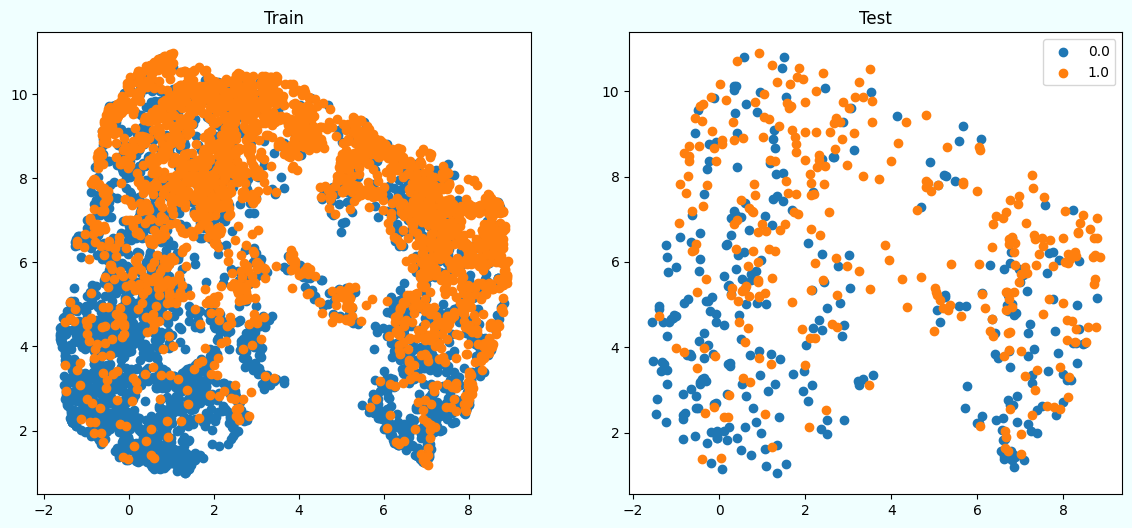

In [26]:
plt.figure(figsize=(14, 6), facecolor="azure")

plt.subplot(1, 2, 1)
for label in np.unique(labels):
    tmp = umap_nn_train[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    plt.title('Train')

plt.subplot(1, 2, 2)
for label in np.unique(test_labels):
    tmp = umap_nn_test[test_labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    plt.title('Test')

plt.legend()
plt.show()

In [27]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

In [28]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}


y_train_t = labels
X_train_t = train_results
y_test_t = test_labels
X_test_t = test_results

clf_lr_1.fit(X_train_t, y_train_t)

y_pred = clf_lr_1.predict(X_test_t)

results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
results['test_f1'].append( f1_score(y_test_t, y_pred) ) 

metrics = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

In [29]:
confusion_matrix(y_test_t, y_pred)

array([[222,  75],
       [120, 178]])

In [30]:
metrics

{'Accuracy': array([0.67226891]), 'F1 Score': array([0.646098])}

# Test using CV

In [ ]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}

embedding_dims = 100
batch_size = 128
epochs = 1000
lr = 0.001

for j, (train_index, val_index, test_index) in enumerate(cv_fold_i):
    train_ds = FakeNews(embeddings_table, df['assestment'].values, train_index)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    
    val_ds = FakeNews(embeddings_table, df['assestment'].values, val_index)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)

    test_ds = FakeNews(embeddings_table, df['assestment'].values, test_index)
    test_loader = DataLoader(test_ds, batch_size=batch_size//2, shuffle=False, num_workers=2)

    
    model = Network(embedding_dims)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = TripletLoss()

    val_prev = np.inf
    
    model.train()
    for epoch in tqdm(range(epochs), desc=f"Epochs {j}"):
        running_loss = []
        for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
            anchor_claim = anchor_claim.to(device)
            positive_claim = positive_claim.to(device)
            negative_claim = negative_claim.to(device)

            optimizer.zero_grad()
            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            running_loss.append(loss.cpu().detach().numpy())

        model.eval()
    
        val_loss = []
        for anchor_claim, positive_claim, negative_claim, _ in val_loader:
            anchor_claim = anchor_claim.to(device)
            positive_claim = positive_claim.to(device)
            negative_claim = negative_claim.to(device)

            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            val_loss.append(loss.cpu().detach().numpy())

        model.train()
        
        if np.mean(val_loss) < val_prev:
            val_prev = np.mean(val_loss)
            torch.save(model, f'model_cv{j}.pt')
        
        if epoch%100 == 0:
            print(f"{j} Epoch: {epoch+1}/{epochs} - Train Loss: {np.mean(running_loss):.4f};",
                  f" Val Loss: {np.mean(val_loss):.4f} Val loss best {val_prev:.4f}"
             )
            
    
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in train_loader:
            anchor_claim = claim.to(device)

            train_results.append(model(anchor_claim).cpu().numpy())
            labels.append(label)


    train_results = np.concatenate(train_results) 
    labels = np.concatenate(labels)

    
    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in test_loader:
            anchor_claim = claim.to(device)

            test_results.append(model(anchor_claim).cpu().numpy())
            test_labels.append(label)


    test_results = np.concatenate(test_results)
    test_labels = np.concatenate(test_labels)

    
    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    

### Get use best models

In [ ]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}


for j, (train_index, val_index, test_index) in enumerate(cv_fold_i):
    train_ds = FakeNews(embeddings_table, df['assestment'].values, train_index)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    
    val_ds = FakeNews(embeddings_table, df['assestment'].values, val_index)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)

    test_ds = FakeNews(embeddings_table, df['assestment'].values, test_index)
    test_loader = DataLoader(test_ds, batch_size=batch_size//2, shuffle=False, num_workers=2)

    
    model = Network(embedding_dims)
    model = torch.load(f'model_cv{j}.pt')
    model = model.to(device)

    model.eval()
   
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in train_loader:
            anchor_claim = claim.to(device)

            train_results.append(model(anchor_claim).cpu().numpy())
            labels.append(label)


    train_results = np.concatenate(train_results) 
    labels = np.concatenate(labels)

    
    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in test_loader:
            anchor_claim = claim.to(device)

            test_results.append(model(anchor_claim).cpu().numpy())
            test_labels.append(label)


    test_results = np.concatenate(test_results)
    test_labels = np.concatenate(test_labels)

    
    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    

In [ ]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}

embedding_dims = 100
batch_size = 128
epochs = 1000
lr = 0.001

for j, (train_index, val_index, test_index) in enumerate(cv_Kfold_i):
    train_ds = FakeNews(embeddings_table, df['assestment'].values, train_index)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    
    val_ds = FakeNews(embeddings_table, df['assestment'].values, val_index)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)

    test_ds = FakeNews(embeddings_table, df['assestment'].values, test_index)
    test_loader = DataLoader(test_ds, batch_size=batch_size//2, shuffle=False, num_workers=2)

    
    model = Network(embedding_dims)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = TripletLoss()

    val_prev = np.inf
    
    model.train()
    for epoch in tqdm(range(epochs), desc=f"Epochs {j}"):
        running_loss = []
        for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
            anchor_claim = anchor_claim.to(device)
            positive_claim = positive_claim.to(device)
            negative_claim = negative_claim.to(device)

            optimizer.zero_grad()
            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            running_loss.append(loss.cpu().detach().numpy())

        model.eval()
    
        val_loss = []
        for anchor_claim, positive_claim, negative_claim, _ in val_loader:
            anchor_claim = anchor_claim.to(device)
            positive_claim = positive_claim.to(device)
            negative_claim = negative_claim.to(device)

            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            val_loss.append(loss.cpu().detach().numpy())

        model.train()
        
        if np.mean(val_loss) < val_prev:
            val_prev = np.mean(val_loss)
            torch.save(model, f'model_cv{j}.pt')
        
        if epoch%100 == 0:
            print(f"{j} Epoch: {epoch+1}/{epochs} - Train Loss: {np.mean(running_loss):.4f};",
                  f" Val Loss: {np.mean(val_loss):.4f} Val loss best {val_prev:.4f}"
             )
            
    
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in train_loader:
            anchor_claim = claim.to(device)

            train_results.append(model(anchor_claim).cpu().numpy())
            labels.append(label)


    train_results = np.concatenate(train_results) 
    labels = np.concatenate(labels)

    
    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in test_loader:
            anchor_claim = claim.to(device)

            test_results.append(model(anchor_claim).cpu().numpy())
            test_labels.append(label)


    test_results = np.concatenate(test_results)
    test_labels = np.concatenate(test_labels)

    
    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    